In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
% cd '/content/drive/MyDrive/PyTorch'

/content/drive/MyDrive/PyTorch


In [ ]:
train_path = 'data/Rotten-Tomatoes/train.csv'
test_path = 'data/Rotten-Tomatoes/test.csv'
val_path = 'data/Rotten-Tomatoes/val.csv'

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# get to know the data

In [ ]:
df = pd.read_csv(train_path, sep='\t')
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,98294,5151,`` terrible,0
1,20122,894,"Before long , you 're desperate for the evenin...",0
2,55614,2777,"particularly joyless , and exceedingly dull",0
3,101112,5314,as tiresome as 9 seconds,0
4,99492,5217,"cold , grey , antiseptic and emotionally desic...",0


In [ ]:
df.describe()

,PhraseId,SentenceId,Sentiment
count,109241.000000,109241.000000,109241.000000
mean,78026.673071,4079.336476,2.063584
std,45002.709018,2500.114703,0.893825
min,1.000000,1.000000,0.000000
25%,39033.000000,1862.000000,2.000000
50%,78030.000000,4017.000000,2.000000
75%,116972.000000,6240.000000,3.000000
max,156060.000000,8544.000000,4.000000


In [ ]:
df = pd.read_csv(train_path, sep='\t')
for i in df.values:
  if i[2] == '':
    print(i[0])

In [ ]:
df = pd.read_csv(train_path, sep='\t')
df.info()
df.to_csv('data/Rotten-Tomatoes/Train.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109241 entries, 0 to 109240
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    109241 non-null  int64 
 1   SentenceId  109241 non-null  int64 
 2   Phrase      109241 non-null  object
 3   Sentiment   109241 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 3.3+ MB


In [ ]:
df = pd.read_csv(test_path, sep='\t')
df.info()
df.to_csv('data/Rotten-Tomatoes/Test.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23409 entries, 0 to 23408
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   PhraseId    23409 non-null  int64 
 1   SentenceId  23409 non-null  int64 
 2   Phrase      23409 non-null  object
 3   Sentiment   23409 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 731.7+ KB


In [ ]:
df = pd.read_csv(val_path, sep='\t')
df.info()
df.to_csv('data/Rotten-Tomatoes/Val.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23410 entries, 0 to 23409
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   PhraseId    23410 non-null  int64 
 1   SentenceId  23410 non-null  int64 
 2   Phrase      23410 non-null  object
 3   Sentiment   23410 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 731.7+ KB


In [ ]:
df = pd.read_csv('data/Rotten-Tomatoes/Train.csv')
df.head()

,Unnamed: 0,PhraseId,SentenceId,Phrase,Sentiment
0,0,98294,5151,`` terrible,0
1,1,20122,894,"Before long , you 're desperate for the evenin...",0
2,2,55614,2777,"particularly joyless , and exceedingly dull",0
3,3,101112,5314,as tiresome as 9 seconds,0
4,4,99492,5217,"cold , grey , antiseptic and emotionally desic...",0


In [ ]:
import os
import random
import time
import string
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torchtext
from torchtext import data
import torch.optim as optim
from torchtext.vocab import Vectors
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchsummary import summary

In [ ]:
%time
def load_data(file_path, device):

    tokenizer = lambda x: str(x).translate(str.maketrans('', '', string.punctuation)).strip().split()
    TEXT = data.Field(sequential=True, lower=True, include_lengths=True, tokenize=tokenizer)
    LABEL = data.Field(sequential=False, use_vocab=False)
    
    trn_dataField = [('Unnamed: 0', None), ('PhraseId', None), ('SentenceId', None), ('Phrase', TEXT), ('Sentiment', LABEL)]
    tst_dataField = [('Unnamed: 0', None), ('PhraseId', None), ('SentenceId', None), ('Phrase', TEXT), ('Sentiment', LABEL)]
    val_dataField = [('Unnamed: 0', None), ('PhraseId', None), ('SentenceId', None), ('Phrase', TEXT), ('Sentiment', LABEL)]
    
    train = data.TabularDataset(path=os.path.join(file_path, 'Train.csv'), format='csv', skip_header=True, fields=trn_dataField)
    test = data.TabularDataset(path=os.path.join(file_path, 'Test.csv'), format='csv', skip_header=True, fields=tst_dataField)
    valid = data.TabularDataset(path=os.path.join(file_path, 'Val.csv'), format='csv', skip_header=True, fields=val_dataField)
    
    cache = ('/content/drive/MyDrive/PyTorch/.vector_cache')
    if not os.path.exists(cache):
        os.mkdir(cache)

    vector = torchtext.vocab.GloVe('6B',dim=100)

    TEXT.build_vocab(train, vectors=vector, unk_init=torch.Tensor.normal_)
    
    train_iter, valid_iter, test_iter = data.BucketIterator.splits((train, valid, test), device=device, batch_size=64, sort_within_batch=True, sort_key = lambda x: len(x.Phrase))
    return TEXT, LABEL, train_iter, valid_iter, test_iter, train


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TEXT, LABEL, train_iter, valid_iter, test_iter, train = load_data('/content/drive/MyDrive/PyTorch/data/Rotten-Tomatoes', device)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.63 µs


In [ ]:
# fancy stuff
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [ ]:
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=pad_idx)
        
        self.rnn = nn.LSTM(embedding_size, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        
        if bidirectional:
            self.fc = nn.Linear(2 * hidden_dim, output_dim)
        else:
            self.fc = nn.Linear(hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, text, lengths):
        
        embedded = self.embedding(text)   #embedded : [sen_len, batch_size, emb_dim]
        
        packed_embedded = pack_padded_sequence(embedded, lengths.to('cpu'))
        
        # packed_output : [num_word, emb_dim]     hidden : [num_layers * num_direction, batch_size, hid_dim]    
        # cell : [num_layers * num_direction, batch_size, hid_dim]
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        output, output_length = pad_packed_sequence(packed_output)
        
        hidden = self.dropout(torch.cat([hidden[-2,:,:], hidden[-1,:,:]], dim=1)).squeeze()
         # hidden : [batch_size, hid_dim * num_dir]
        return self.fc(hidden)
    
    
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 5
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = SentimentModel(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)

In [ ]:
len(TEXT.vocab)

16373

In [ ]:
pretrained_embeddings = TEXT.vocab.vectors
print(TEXT.vocab.vectors.shape)
model.embedding.weight.data.copy_(pretrained_embeddings)

torch.Size([16373, 100])


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.1580, -0.2077,  0.0084,  ..., -1.2656, -0.2771, -0.3230],
        [ 0.2747,  0.2016,  1.0163,  ...,  0.2453, -0.2703,  0.4911],
        [-0.2909, -0.7498, -0.2997,  ..., -0.4769,  0.4399, -0.2560]])

In [ ]:
model.embedding.weight.requires_grad=False

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

cuda:0


In [ ]:
loss_function = nn.CrossEntropyLoss()
loss_function = loss_function.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def accuracy(preds, y):
    '''
    Return accuracy per batch ..
    '''
    preds = torch.argmax(torch.softmax(preds, dim=1), dim=1)
    correct = (preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model, train_iterator, val_iterator, optimizer, loss_function, epochs, results):
  
  for j in range(epochs):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    print(color.BOLD + "Training for epoch = " + color.END, j)
    for i, batch in tqdm(enumerate(train_iterator)):
        
        optimizer.zero_grad()

        text, text_lengths = batch.Phrase

        if(torch.min(text_lengths) <= 0): 
            continue
        #print(text, text_lengths)
        predictions = model(text, text_lengths)
        
        loss = loss_function(predictions, batch.Sentiment)
        
        acc = accuracy(predictions, batch.Sentiment)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    print(f"[{j}/{epochs}] : epoch_loss: {epoch_loss / len(train_iterator):.4f} : epoch_acc: {epoch_acc / len(train_iterator):.4f}")
    val_loss, val_acc = evaluate(model, val_iterator, loss_function)

    train_loss = epoch_loss / len(train_iterator)
    train_acc = epoch_acc / len(train_iterator)
    results = results.append({"Epoch": (j+1), \
                            "Train Loss": train_loss, "Train Accuracy": train_acc, \
                            "Val Loss": val_loss, "Val Accuracy": val_acc},ignore_index=True)
    
    torch.save(model.state_dict(), f"./data/Sentiment_models/model1/glove_model_{j+1}.pth")
    results.to_csv(f"./data/Sentiment_models/model1/glove_Results_{EMBEDDING_DIM}.csv")


  return train_loss, train_acc

In [ ]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    print("Validation")
    with torch.no_grad():
        for i, batch in tqdm(enumerate(iterator)):
            
            text, text_lengths = batch.Phrase
            test_lengths = text_lengths.to('cpu')
            if(torch.min(text_lengths) <= 0): 
                continue
            else:
                predictions = model(text, text_lengths)
            
            loss = criterion(predictions, batch.Sentiment)
        
            acc = accuracy(predictions, batch.Sentiment)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()

    print(f"val_loss: {epoch_loss / len(iterator):.4f} : val_acc: {epoch_acc / len(iterator):.4f}")
    print("--------------------------------------------------------------------")
    print();print()
    return epoch_loss / len(iterator),  epoch_acc / len(iterator)

In [ ]:
epochs = 60
results = pd.DataFrame(columns=["Epoch","Train Loss","Train Accuracy","Val Loss","Val Accuracy"])
train(model, train_iter, valid_iter, optimizer, loss_function, epochs, results)

Training for epoch =  0



[0/60] : epoch_loss: 0.9878 : epoch_acc: 0.5865
Validation



val_loss: 0.9128 : val_acc: 0.6184
--------------------------------------------------------------------


Training for epoch =  1



[1/60] : epoch_loss: 0.8982 : epoch_acc: 0.6174
Validation



val_loss: 0.8727 : val_acc: 0.6314
--------------------------------------------------------------------


Training for epoch =  2



[2/60] : epoch_loss: 0.8433 : epoch_acc: 0.6429
Validation



val_loss: 0.8370 : val_acc: 0.6517
--------------------------------------------------------------------


Training for epoch =  3



[3/60] : epoch_loss: 0.7920 : epoch_acc: 0.6632
Validation



val_loss: 0.8156 : val_acc: 0.6614
--------------------------------------------------------------------


Training for epoch =  4



[4/60] : epoch_loss: 0.7500 : epoch_acc: 0.6788
Validation



val_loss: 0.7988 : val_acc: 0.6686
--------------------------------------------------------------------


Training for epoch =  5



[5/60] : epoch_loss: 0.7093 : epoch_acc: 0.6966
Validation



val_loss: 0.8071 : val_acc: 0.6682
--------------------------------------------------------------------


Training for epoch =  6



[6/60] : epoch_loss: 0.6748 : epoch_acc: 0.7101
Validation



val_loss: 0.8078 : val_acc: 0.6737
--------------------------------------------------------------------


Training for epoch =  7



[7/60] : epoch_loss: 0.6438 : epoch_acc: 0.7231
Validation



val_loss: 0.8033 : val_acc: 0.6743
--------------------------------------------------------------------


Training for epoch =  8



[8/60] : epoch_loss: 0.6160 : epoch_acc: 0.7346
Validation



val_loss: 0.8259 : val_acc: 0.6734
--------------------------------------------------------------------


Training for epoch =  9



[9/60] : epoch_loss: 0.5873 : epoch_acc: 0.7465
Validation



val_loss: 0.8423 : val_acc: 0.6672
--------------------------------------------------------------------


Training for epoch =  10



[10/60] : epoch_loss: 0.5633 : epoch_acc: 0.7559
Validation



val_loss: 0.8644 : val_acc: 0.6720
--------------------------------------------------------------------


Training for epoch =  11



[11/60] : epoch_loss: 0.5373 : epoch_acc: 0.7670
Validation



val_loss: 0.8951 : val_acc: 0.6708
--------------------------------------------------------------------


Training for epoch =  12



[12/60] : epoch_loss: 0.5140 : epoch_acc: 0.7778
Validation



val_loss: 0.9139 : val_acc: 0.6639
--------------------------------------------------------------------


Training for epoch =  13



[13/60] : epoch_loss: 0.4910 : epoch_acc: 0.7871
Validation



val_loss: 0.9592 : val_acc: 0.6568
--------------------------------------------------------------------


Training for epoch =  14



[14/60] : epoch_loss: 0.4691 : epoch_acc: 0.7969
Validation



val_loss: 0.9768 : val_acc: 0.6640
--------------------------------------------------------------------


Training for epoch =  15



[15/60] : epoch_loss: 0.4502 : epoch_acc: 0.8055
Validation



val_loss: 1.0347 : val_acc: 0.6581
--------------------------------------------------------------------


Training for epoch =  16



[16/60] : epoch_loss: 0.4328 : epoch_acc: 0.8120
Validation



val_loss: 1.0484 : val_acc: 0.6548
--------------------------------------------------------------------


Training for epoch =  17



[17/60] : epoch_loss: 0.4118 : epoch_acc: 0.8210
Validation



val_loss: 1.1125 : val_acc: 0.6502
--------------------------------------------------------------------


Training for epoch =  18



[18/60] : epoch_loss: 0.4023 : epoch_acc: 0.8276
Validation



val_loss: 1.1167 : val_acc: 0.6559
--------------------------------------------------------------------


Training for epoch =  19



[19/60] : epoch_loss: 0.3837 : epoch_acc: 0.8337
Validation



val_loss: 1.1614 : val_acc: 0.6494
--------------------------------------------------------------------


Training for epoch =  20



[20/60] : epoch_loss: 0.3741 : epoch_acc: 0.8395
Validation



val_loss: 1.2232 : val_acc: 0.6492
--------------------------------------------------------------------


Training for epoch =  21



[21/60] : epoch_loss: 0.3604 : epoch_acc: 0.8459
Validation



val_loss: 1.2192 : val_acc: 0.6436
--------------------------------------------------------------------


Training for epoch =  22



[22/60] : epoch_loss: 0.3495 : epoch_acc: 0.8494
Validation



val_loss: 1.2607 : val_acc: 0.6423
--------------------------------------------------------------------


Training for epoch =  23



[23/60] : epoch_loss: 0.3381 : epoch_acc: 0.8548
Validation



val_loss: 1.3401 : val_acc: 0.6418
--------------------------------------------------------------------


Training for epoch =  24



[24/60] : epoch_loss: 0.3295 : epoch_acc: 0.8602
Validation



val_loss: 1.3125 : val_acc: 0.6404
--------------------------------------------------------------------


Training for epoch =  25



[25/60] : epoch_loss: 0.3214 : epoch_acc: 0.8626
Validation



val_loss: 1.3430 : val_acc: 0.6476
--------------------------------------------------------------------


Training for epoch =  26



[26/60] : epoch_loss: 0.3129 : epoch_acc: 0.8647
Validation



val_loss: 1.3901 : val_acc: 0.6401
--------------------------------------------------------------------


Training for epoch =  27



[27/60] : epoch_loss: 0.3060 : epoch_acc: 0.8689
Validation



val_loss: 1.4410 : val_acc: 0.6442
--------------------------------------------------------------------


Training for epoch =  28



[28/60] : epoch_loss: 0.2974 : epoch_acc: 0.8734
Validation



val_loss: 1.4338 : val_acc: 0.6422
--------------------------------------------------------------------


Training for epoch =  29



[29/60] : epoch_loss: 0.2945 : epoch_acc: 0.8730
Validation



val_loss: 1.4398 : val_acc: 0.6403
--------------------------------------------------------------------


Training for epoch =  30



[30/60] : epoch_loss: 0.2897 : epoch_acc: 0.8757
Validation



val_loss: 1.4353 : val_acc: 0.6408
--------------------------------------------------------------------


Training for epoch =  31



[31/60] : epoch_loss: 0.2838 : epoch_acc: 0.8786
Validation



val_loss: 1.5111 : val_acc: 0.6458
--------------------------------------------------------------------


Training for epoch =  32



[32/60] : epoch_loss: 0.2784 : epoch_acc: 0.8798
Validation



val_loss: 1.5119 : val_acc: 0.6388
--------------------------------------------------------------------


Training for epoch =  33



[33/60] : epoch_loss: 0.2734 : epoch_acc: 0.8820
Validation



val_loss: 1.4721 : val_acc: 0.6403
--------------------------------------------------------------------


Training for epoch =  34



[34/60] : epoch_loss: 0.2700 : epoch_acc: 0.8831
Validation



val_loss: 1.4942 : val_acc: 0.6401
--------------------------------------------------------------------


Training for epoch =  35



[35/60] : epoch_loss: 0.2676 : epoch_acc: 0.8832
Validation



val_loss: 1.5687 : val_acc: 0.6418
--------------------------------------------------------------------


Training for epoch =  36



[36/60] : epoch_loss: 0.2638 : epoch_acc: 0.8859
Validation



val_loss: 1.5362 : val_acc: 0.6419
--------------------------------------------------------------------


Training for epoch =  37



[37/60] : epoch_loss: 0.2603 : epoch_acc: 0.8883
Validation



val_loss: 1.6178 : val_acc: 0.6424
--------------------------------------------------------------------


Training for epoch =  38



[38/60] : epoch_loss: 0.2581 : epoch_acc: 0.8874
Validation



val_loss: 1.6205 : val_acc: 0.6380
--------------------------------------------------------------------


Training for epoch =  39



[39/60] : epoch_loss: 0.2562 : epoch_acc: 0.8910
Validation



val_loss: 1.5760 : val_acc: 0.6417
--------------------------------------------------------------------


Training for epoch =  40



[40/60] : epoch_loss: 0.2508 : epoch_acc: 0.8929
Validation



val_loss: 1.6800 : val_acc: 0.6398
--------------------------------------------------------------------


Training for epoch =  41



[41/60] : epoch_loss: 0.2494 : epoch_acc: 0.8909
Validation



val_loss: 1.6148 : val_acc: 0.6419
--------------------------------------------------------------------


Training for epoch =  42



[42/60] : epoch_loss: 0.2495 : epoch_acc: 0.8917
Validation



val_loss: 1.6243 : val_acc: 0.6382
--------------------------------------------------------------------


Training for epoch =  43



[43/60] : epoch_loss: 0.2435 : epoch_acc: 0.8930
Validation



val_loss: 1.6363 : val_acc: 0.6405
--------------------------------------------------------------------


Training for epoch =  44



[44/60] : epoch_loss: 0.2416 : epoch_acc: 0.8975
Validation



val_loss: 1.6709 : val_acc: 0.6434
--------------------------------------------------------------------


Training for epoch =  45



[45/60] : epoch_loss: 0.2396 : epoch_acc: 0.8966
Validation



val_loss: 1.6744 : val_acc: 0.6372
--------------------------------------------------------------------


Training for epoch =  46



[46/60] : epoch_loss: 0.2401 : epoch_acc: 0.8946
Validation



val_loss: 1.6889 : val_acc: 0.6358
--------------------------------------------------------------------


Training for epoch =  47



[47/60] : epoch_loss: 0.2398 : epoch_acc: 0.8970
Validation



val_loss: 1.7048 : val_acc: 0.6377
--------------------------------------------------------------------


Training for epoch =  48



[48/60] : epoch_loss: 0.2347 : epoch_acc: 0.8987
Validation



val_loss: 1.6945 : val_acc: 0.6369
--------------------------------------------------------------------


Training for epoch =  49



[49/60] : epoch_loss: 0.2340 : epoch_acc: 0.8985
Validation



val_loss: 1.7567 : val_acc: 0.6360
--------------------------------------------------------------------


Training for epoch =  50



[50/60] : epoch_loss: 0.2327 : epoch_acc: 0.8999
Validation



val_loss: 1.7566 : val_acc: 0.6399
--------------------------------------------------------------------


Training for epoch =  51



[51/60] : epoch_loss: 0.2292 : epoch_acc: 0.9010
Validation



val_loss: 1.6714 : val_acc: 0.6360
--------------------------------------------------------------------


Training for epoch =  52



[52/60] : epoch_loss: 0.2285 : epoch_acc: 0.9018
Validation



val_loss: 1.7155 : val_acc: 0.6385
--------------------------------------------------------------------


Training for epoch =  53



[53/60] : epoch_loss: 0.2287 : epoch_acc: 0.9016
Validation



val_loss: 1.7548 : val_acc: 0.6382
--------------------------------------------------------------------


Training for epoch =  54



[54/60] : epoch_loss: 0.2255 : epoch_acc: 0.8995
Validation



val_loss: 1.7406 : val_acc: 0.6409
--------------------------------------------------------------------


Training for epoch =  55



[55/60] : epoch_loss: 0.2249 : epoch_acc: 0.9015
Validation



val_loss: 1.7056 : val_acc: 0.6363
--------------------------------------------------------------------


Training for epoch =  56



[56/60] : epoch_loss: 0.2249 : epoch_acc: 0.9015
Validation



val_loss: 1.7493 : val_acc: 0.6353
--------------------------------------------------------------------


Training for epoch =  57



[57/60] : epoch_loss: 0.2244 : epoch_acc: 0.9027
Validation



val_loss: 1.7931 : val_acc: 0.6373
--------------------------------------------------------------------


Training for epoch =  58



[58/60] : epoch_loss: 0.2236 : epoch_acc: 0.9016
Validation



val_loss: 1.7268 : val_acc: 0.6330
--------------------------------------------------------------------


Training for epoch =  59



[59/60] : epoch_loss: 0.2216 : epoch_acc: 0.9016
Validation



val_loss: 1.7500 : val_acc: 0.6371
--------------------------------------------------------------------




(0.22162064182881416, 0.9015863793735694)

In [ ]:
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sn 

def confusion_matrix(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    pred_y = np.array([])
    true_y = np.array([])
    model.eval()
    print("Testing")
    with torch.no_grad():
        for i, batch in tqdm(enumerate(iterator)):
            
            text, text_lengths = batch.Phrase
            test_lengths = text_lengths.to('cpu')
            if(torch.min(text_lengths) <= 0): 
                continue
            else:
                predictions = model(text, text_lengths)
            preds = torch.argmax(torch.softmax(predictions, dim=1), dim=1)
            pred_y = np.append(pred_y, preds.detach().cpu().numpy())
            true_y = np.append(true_y, batch.Sentiment.detach().cpu().numpy())
            #print(true_y.shape)
            loss = criterion(predictions, batch.Sentiment)
        
            acc = accuracy(predictions, batch.Sentiment)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()

    print(f"test_loss: {epoch_loss / len(iterator):.4f} : test_acc: {epoch_acc / len(iterator):.4f}")

    cm = sklearn.metrics.confusion_matrix(true_y, pred_y)
    plt.figure(figsize=(6,4))
    sn.heatmap(cm, annot=True, fmt="d") # font size
    plt.show()

    print("--------------------------------------------------------------------")
    print();print()

Testing



test_loss: 1.7583 : test_acc: 0.6323


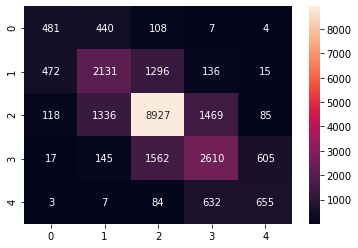

--------------------------------------------------------------------




In [ ]:
confusion_matrix(model, test_iter, loss_function)

In [ ]:
# Plot train and test accuracy and losses

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv(f'./data/Sentiment_models/model1/glove_Results_100.csv')
df.head()

,Unnamed: 0,Epoch,Train Loss,Train Accuracy,Val Loss,Val Accuracy
0,0,1.0,0.987799,0.586483,0.912762,0.618408
1,1,2.0,0.898242,0.617434,0.872749,0.631373
2,2,3.0,0.843333,0.642914,0.836972,0.651662
3,3,4.0,0.791990,0.663247,0.815609,0.661366
4,4,5.0,0.749983,0.678762,0.798787,0.668555


In [ ]:
train_loss = df['Train Loss'].values
train_acc = df['Train Accuracy'].values
val_loss = df['Val Loss'].values
val_acc = df['Val Accuracy'].values

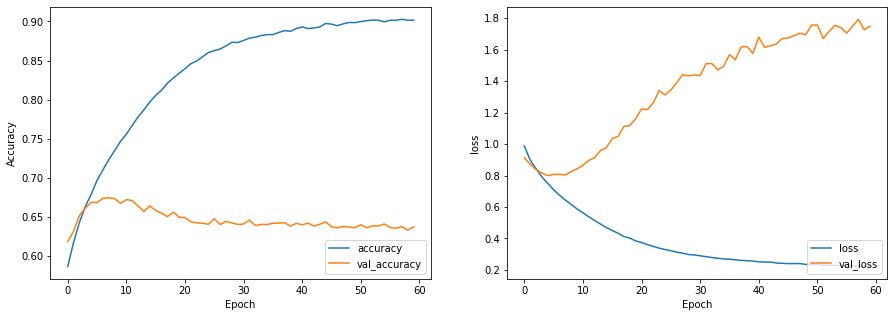

In [ ]:
fig,(ax1,ax2) =  plt.subplots(1,2,figsize=(15,5))

ax1.plot(train_acc, label='accuracy')
ax1.plot(val_acc, label = 'val_accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')

ax2.plot(train_loss, label='loss')
ax2.plot(val_loss, label = 'val_loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('loss')
ax2.legend(loc='lower right')

plt.show()